# Sourcing Restaurant Inspections Data

## Imports

In [3]:
# import pandas, numpy, matplotlib, seaborn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing the requests library
import requests

import urllib.request
from pathlib import Path
import os
from pandas_profiling import ProfileReport
import plotly.express as px

### Resources
 1. [Restaurants in Wake County Data Info](https://www.arcgis.com/home/item.html?id=124c2187da8c41c59bde04fa67eb2872)
 2. [Wake County Open Data](https://data-wake.opendata.arcgis.com/search?tags=restaurants)
 3. [Food Inspection Violations Data Info](https://data.wakegov.com/datasets/Wake::food-inspection-violations/about)
 4. [Wake County Yelp Initiative](https://ash.harvard.edu/news/wake-county-yelp-initiative)

# Fetch food inspections from wakegov

In [4]:
# https://data-wake.opendata.arcgis.com/datasets/food-inspections/explore
# https://www.arcgis.com/home/item.html?id=ebe3ae7f76954fad81411612d7c4fb17
def getFoodInspectionsDf(forceFetch=False): 
    
    # https://maps.wakegov.com/arcgis/rest/services/Inspections/RestaurantInspectionsOpenData/MapServer/1/query?outFields=*&where=1%3D1
    # Sending get request and saving the response as response object
    # extracting data in json
    
    path = Path()
    key = 'inspections.csv'
    filename = path/key
    # If the file does not already exist in the directory, download it
    if os.path.exists(filename) and not forceFetch:
        print('Using pre-fetched inspections data')
        return pd.read_csv(key)
    
    else:
        print('Fetching inspections data...')
        val = 'https://opendata.arcgis.com/datasets/ebe3ae7f76954fad81411612d7c4fb17_1.geojson'
        rows = []
        r = requests.get(url = val)
        data = r.json()
        #print(data)
        for d in data:
            data = r.json()['features']
            for d in data:
                rows.append(d['properties'])
        inspections = pd.DataFrame(rows)
        inspections.to_csv(key, index=False)
        print('Done')
        return inspections

food_inspections_raw = getFoodInspectionsDf(forceFetch=False)

Using pre-fetched inspections data


In [5]:
food_inspections_raw.head()

,OBJECTID,HSISID,SCORE,DATE_,DESCRIPTION,TYPE,INSPECTOR,PERMITID
0,22332274,4092017542,94.5,2017-04-07T04:00:00Z,"Inspection conducted by Joshua Volkan, supervi...",Inspection,Anne-Kathrin Bartoli,76
1,22332275,4092017542,92.0,2017-11-08T05:00:00Z,manager owns two deep chest freezers that are ...,Inspection,Laura McNeill,76
2,22332276,4092017542,95.0,2018-03-23T04:00:00Z,NaN,Inspection,Laura McNeill,76
3,22332277,4092017542,93.5,2018-09-07T04:00:00Z,"*NOTICE* EFFECTIVE JANUARY 1, 2019, THE NC FOO...",Inspection,Laura McNeill,76
4,22332278,4092017542,93.0,2019-04-04T04:00:00Z,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Joanne Rutkofske,76


# Preprocessing

In [6]:
def preprocess_inspections(df):
        
    # drop duplicates
    df.drop_duplicates(inplace=True)
                       
    # convert date to datetime & only get date
    df['DATE_'] = pd.to_datetime(df['DATE_']).dt.date
    df.rename(columns={"DATE_": "DATE"}, inplace=True)

    # filter only since beginning of 2016 - we don't want data before that
    df = df[df['DATE'] >= pd.to_datetime('2016-01-01').date()].reset_index(drop=True)
    
    # drop irrelevant columns
    df.drop(['PERMITID', 'DESCRIPTION'], axis=1, inplace=True)
    
    return df

## Save Preprocessed DataFrame

In [7]:
df = preprocess_inspections(food_inspections_raw.copy())
df.to_csv('preprocessed_inspections.csv', index=False)

In [8]:
print(df.shape)
df.head()

(36657, 6)


,OBJECTID,HSISID,SCORE,DATE,TYPE,INSPECTOR
0,22332274,4092017542,94.5,2017-04-07,Inspection,Anne-Kathrin Bartoli
1,22332275,4092017542,92.0,2017-11-08,Inspection,Laura McNeill
2,22332276,4092017542,95.0,2018-03-23,Inspection,Laura McNeill
3,22332277,4092017542,93.5,2018-09-07,Inspection,Laura McNeill
4,22332278,4092017542,93.0,2019-04-04,Inspection,Joanne Rutkofske


In [9]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36657 entries, 0 to 36656
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OBJECTID   36657 non-null  int64  
 1   HSISID     36657 non-null  int64  
 2   SCORE      36657 non-null  float64
 3   DATE       36657 non-null  object 
 4   TYPE       36657 non-null  object 
 5   INSPECTOR  36657 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.7+ MB


None

In [10]:
df.isna().sum()

OBJECTID     0
HSISID       0
SCORE        0
DATE         0
TYPE         0
INSPECTOR    0
dtype: int64

In [11]:
display({column: len(df[column].unique()) for column in df.columns})

{'OBJECTID': 36657,
 'HSISID': 3882,
 'SCORE': 53,
 'DATE': 1623,
 'TYPE': 2,
 'INSPECTOR': 61}

In [12]:
df.dtypes

OBJECTID       int64
HSISID         int64
SCORE        float64
DATE          object
TYPE          object
INSPECTOR     object
dtype: object

# Profile Report 

In [27]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

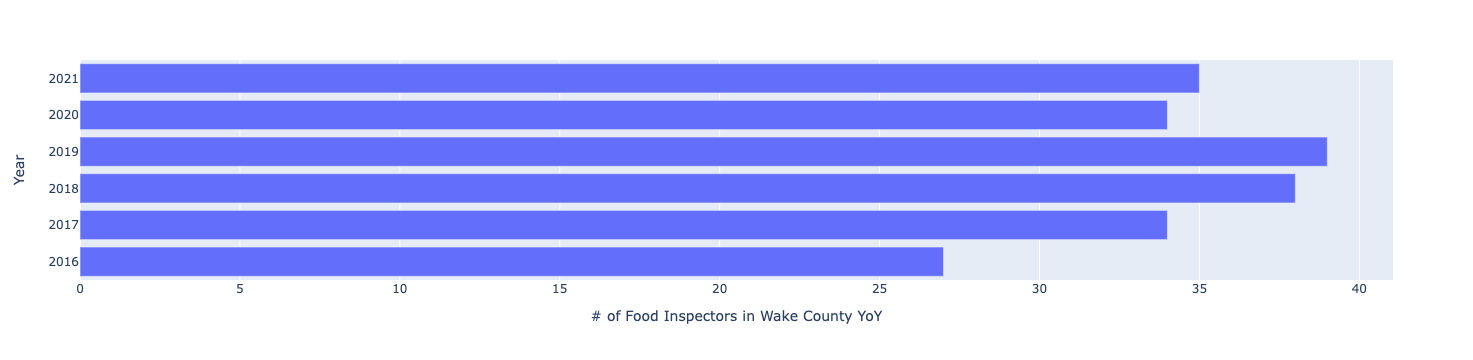

In [26]:
disp = df.copy()
disp['DATE'] =  pd.to_datetime(disp['DATE'])
disp['Year'] = disp['DATE'].dt.year
disp = (disp.groupby('Year')['INSPECTOR'].nunique())
disp = pd.DataFrame(disp).reset_index()
disp.columns = ['Year', '# of Inspectors']
fig = px.bar(disp, y="Year", x="# of Inspectors", orientation='h')
fig.update_xaxes(title='# of Food Inspectors in Wake County YoY')
fig.show()